# Text Summarization  
Text summarization is the process of distilling the most important information from a source (or sources) to produce an abridged version or summary.  
<img src="img/text_sum.png" alt="Markdown Monster icon" style="float: center; margin-right: 10px;" />   


### Types of Text Summarization Methods  
Text summarization methods can be classified into different types  
<img src="img/text_sum_types.png" alt="Markdown Monster icon" style="float: center; margin-right: 10px;" />  

i. Based on input type:  

    - Single Document, where the input length is short. Many of the early summarization systems dealt with single document summarization.
    - Multi Document, where the input can be arbitrarily long.  

ii. Based on the purpose:  

    - Generic, where the model makes no assumptions about the domain or content of the text to be summarized and treats all inputs as homogeneous. The majority of the work that has been done revolves around generic summarization.  
    - Domain-specific, where the model uses domain-specific knowledge to form a more accurate summary. For example, summarizing research papers of a specific domain, biomedical documents, etc.  
    - Query-based, where the summary only contains information which answers natural language questions about the input text.  

iii. Based on output type:  

    - Extractive, where important sentences are selected from the input text to form a summary. Most summarization approaches today are extractive in nature.  
    - Abstractive, where the model forms its own phrases and sentences to offer a more coherent summary, like what a human would generate. This approach is definitely more appealing, but much more difficult than extractive summarization.  


## Text summerization

In [1]:
# !pip install plotly

In [3]:
import numpy as np # linear algebra
import spacy


import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import string
import re
from collections import Counter
from time import time
import heapq

# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from nltk.corpus import stopwords
import nltk
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

#stopwords = stopwords.words('english')
sns.set_context('notebook')

In [4]:
# nlp = spacy.load('en_core_web_sm')
nlp = spacy.load("en_core_web_sm")

In [5]:
# import dataset

# replace with appropriate path
# path = 'data/winemag-data_first150k.csv'
# data = pd.read_csv(path, nrows=nrows, usecols =['points', 'description'], encoding='utf-8')

nrows = 5000 # read only first 5000 rows
path = '/Volumes/GoogleDrive/My Drive/PROJECTS/AIMS-Senegal/Course_Materials_2022/notebooks/data/news_summary.csv'
data = pd.read_csv(path, encoding='iso-8859-1', nrows=nrows)
data = data.dropna()

In [6]:
data.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [7]:
data['text'][0]

'The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.'

In [8]:
data['ctext'][0]

'The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the Dama

### Text preprocessing

In [65]:
# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
# punctuations = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~©'

def cleanup_text(text):
    """apply spacy lemmatization"""
    text_sp = nlp(text)
    tokens = [token.lemma_ for token in text_sp \
        if (token.lemma_ not in string.punctuation) and \
            (not token.is_stop) and \
                (token.lemma_ != '-PRON-')]

    return ' '.join(tokens)


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text


def normalize_text(text):
    """Clean text and normalize"""
    
    text = re.sub('<pre>.*?</pre>', '', text, flags=re.DOTALL)
    text = re.sub('<code>.*?</code>', '', text, flags=re.DOTALL)
    text = re.sub('<[^>]+>©', '', text, flags=re.DOTALL)
    text = text.replace("\n", "")

    text = re.sub("(\\t)", " ", str(text))
    text = re.sub("(\\r)", " ", str(text))
    text = re.sub("(\\n)", " ", str(text))
        
        # remove html tags
    text = strip_html_tags(text)
        
        # remove URL from text
    text = re.sub(r"http\S+", "", text)        
        
        # Remove _ if it occurs more than one time consecutively
    text = re.sub("(__+)", " ", str(text))

        # Remove - if it occurs more than one time consecutively
    text = re.sub("(--+)", " ", str(text))

        # Remove ~ if it occurs more than one time consecutively
    text = re.sub("(~~+)", " ", str(text))

        # Remove + if it occurs more than one time consecutively
    text = re.sub("(\+\++)", " ", str(text))

        # Remove . if it occurs more than one time consecutively
    text = re.sub("(\.\.+)", " ", str(text))

    # Remove the characters - <>()|&©ø"',;?~*!
    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(text))

    # Remove mailto:
    text = re.sub("(mailto:)", " ", str(text))

    # Remove \x9* in text
    text = re.sub(r"(\\x9\d)", " ", str(text))

    # Replace INC nums to INC_NUM
    text = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(text))

    # Replace CM# and CHG# to CM_NUM
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(text))

        # Remove punctuations at the end of a word
    text = re.sub("(\.\s+)", " ", str(text))
    text = re.sub("(\-\s+)", " ", str(text))
    text = re.sub("(\:\s+)", " ", str(text))

    # Replace any url to only the domain name
    try:
        url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(text))
        repl_url = url.group(3)
        text = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(text))
    except:
        pass

    # Remove multiple spaces
    text = re.sub("(\s+)", " ", str(text))

    return text

In [33]:
data['ctext_cleaned_1'] = data['ctext'].map(lambda x: normalize_text(x))

In [34]:
n = 3
print('Before normalizing text-----\n')
print(data['ctext'][n])
print('\nAfter normalizing text-----\n')
print(data['ctext_cleaned_1'][n])

Before normalizing text-----

Lashkar-e-Taiba's Kashmir commander Abu Dujana was killed in an encounter in a village in Pulwama district of Jammu and Kashmir earlier this week. Dujana, who had managed to give the security forces a slip several times in the past, carried a bounty of Rs 15 lakh on his head.Reports say that Dujana had come to meet his wife when he was trapped inside a house in Hakripora village. Security officials involved in the encounter tried their best to convince Dujana to surrender but he refused, reports say.According to reports, Dujana rejected call for surrender from an Army officer. The Army had commissioned a local to start a telephonic conversation with Dujana. After initiating the talk, the local villager handed over the phone to the army officer."Kya haal hai? Maine kaha, kya haal hai (How are you. I asked, how are you)?" Dujana is heard asking the officer. The officer replies: "Humara haal chhor Dujana. Surrender kyun nahi kar deta. Tu galat kar rha hai (Wh

In [35]:
data['ctext_cleaned'] = data['ctext_cleaned_1'].map(lambda x: cleanup_text(x))

### Analyze article length

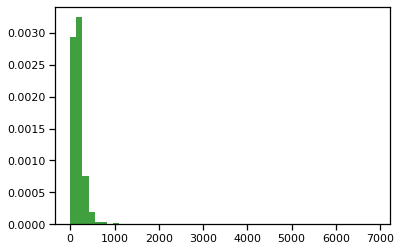

In [13]:
article_lens = data['ctext_cleaned'].map(lambda x: len(x.split()))
n, bins, patches = plt.hist(article_lens, 50, density=True, facecolor='g', alpha=0.75)

## Summarizer using Spacy

1. Convert Paragraphs to Sentences: We first need to convert the whole paragraph into sentences. The most common way of converting paragraphs to sentences is to split the paragraph whenever a period is encountered.

2. Text Preprocessing: After converting paragraph to sentences, we need to remove all the special characters, stop words and numbers from all the sentences.

3. Tokenizing the Sentences: We need to tokenize all the sentences to get all the words that exist in the sentences

4. Find Weighted Frequency of Occurrence: Next we need to find the weighted frequency of occurrences of all the words. We can find the weighted frequency of each word by dividing its frequency by the frequency of the most occurring word.

5. Replace Words by Weighted Frequency in Original Sentences: The final step is to plug the weighted frequency in place of the corresponding words in original sentences and finding their sum. It is important to mention that weighted frequency for the words removed during preprocessing (stop words, punctuation, digits etc.) will be zero and therefore is not required to be added

6. Sort Sentences in Descending Order of Sum: The final step is to sort the sentences in inverse order of their sum. The sentences with highest frequencies summarize the text.

In [17]:
def generate_summary(text_without_removing_dot, cleaned_text, num_sentences=5):
    
    sample_text = text_without_removing_dot
    doc = nlp(sample_text)
    sentence_list=[]
    for idx, sentence in enumerate(doc.sents): # we are using spacy for sentence tokenization
        sentence_list.append(re.sub(r'[^\w\s]','',str(sentence)))

    stopwords = nltk.corpus.stopwords.words('english')

    word_frequencies = {}  
    for word in nltk.word_tokenize(cleaned_text):  
        if word not in stopwords:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1

    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():  
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)

    sentence_scores = {}  
    for sent in sentence_list:  
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]


    summary_sentences = heapq.nlargest(num_sentences, sentence_scores, key=sentence_scores.get)

    summary = ' '.join(summary_sentences)
    print("Original Text:\n")
    print(text_without_removing_dot)
    print('\n\nSummarized text:\n')
    print(summary)

In [36]:
generate_summary(data['ctext_cleaned_1'][8], data['ctext_cleaned'][8], 5)

Original Text:

Two years after helicopter crash near the Bombay High offshore oil field killed two pilots an inquiry by the Air Accident Investigation Bureau AAIB found that the chopper was flying at critically low height without the pilots realising it The Pawan Hans helicopter was on training sortie on the evening of November 2015 Aviation regulator Director General of Civil Aviation DGCA had asked AAIB to conduct an inquiry The inquiry report which was made public on Wednesday said that the main pilot was flying low and that the other did not realise it After taking off the Rontappmeyer RYTYR helicopter may have faced difficulties as the moon was waning the report said The report mentioned that the instructor Captain Samuel wasn disoriented and was aware of the low height of the helicopter He alerted Captain TK Guha little late but even after realising that Guha wasn able to manage the situation Samuel did not take control of the helicopter.AAIB recommended that ONGC which owns Bom

In [37]:
generate_summary(data['ctext_cleaned_1'][10], data['ctext_cleaned'][10], 5)

Original Text:

The Food Safety and Standards Authority of India FSSAI is in the process of creating network of food banking partners to collect and distribute leftover food from large parties and weddings to the hungry.A notification to create separate category of food business operators FBOs who will be licensed to deal only with leftover food has been drafted to ensure the quality of food We are looking at partnering with NGOs or organisations that collect store and distribute surplus food to ensure they maintain certain hygiene and health standards when handling food said Pawan Agarwal CEO of FSSAI Tonnes of food is wasted annually We are looking at creating mechanism through which food can be collected from restaurants weddings large-scale parties says Pawan Agarwal All food whether it is paid for or distributed free must meet the country food safety and hygiene standards he said.The organisations in the business of collecting leftover food will now have to work in collaboration w

## Text summarization using word2vec

In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re

from nltk.tokenize import sent_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.models.keyedvectors as word2vec
import gc
import string

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from helper.contractions import CONTRACTION_MAP
from bs4 import BeautifulSoup

from nltk.corpus import stopwords

In [20]:
# data = pd.read_csv(path, nrows=8000, encoding='latin1')
# data = data.dropna()
# data.head()

#### Sentence tokenization
We can use the NLTK’s sentence tokenizer to obtain the sentence level tokens.

In [21]:
def sentence_tokenizer(text):
    """Modulke to create sentenc tokens"""
    return sent_tokenize(text, language = 'en')

In [30]:
article_list = data['ctext_cleaned_1'].map(lambda x: sent_tokenize(x))

In [31]:
article_list[2]

['The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna amended its marital declaration form on Thursday, replacing the word ?virgin?',
 'with ?unmarried?',
 'after controversy.Until now, new recruits to the super-specialty medical institute in the state capital were required to declare if they were bachelors, widowers or virgins.IGIMS medical superintendent Dr Manish Mandal said institute director Dr NR Biswas held a meeting on Thursday morning before directing that the word ?virgin?',
 'on the marital declaration form be immediately replaced with ?unmarried?.',
 'Dr Biswas had just returned after a four-day leave of absence.Earlier, Bihar health minister Mangal Pandey had ended up redefining the very meaning of virginity in his attempts to justify the awkward phrasing of the question in the form.',
 'Following a public furore over the document on Wednesday, the minister told news channels that there was nothing wrong with using the word ?virgin?',
 'because it simply meant

#### Skip-Thought Encoder

We need a way to generate fixed length vector representations for each sentence in our reviews. These representations should encode the inherent semantics and the meaning of the corresponding sentence. The well known Skip-Gram Word2Vec method for generating word embeddings can give us word embeddings for individual words that are present in our model’s vocabulary (some [fancier approaches](https://arxiv.org/abs/1607.04606) can also generate embeddings for words which are not in the model vocabulary using subword information).  

For sentence embeddings, one easy way is to take a weighted sum of the word vectors for the words contained in the sentence. We take a weighted sum because frequently occurring words such as ‘and’, ‘to’ and ‘the’, provide little or no information about the sentence. Some rarely occurring words, which are unique to a few sentences have much more representative power. Hence, we take the weights as being inversely related to the frequency of word occurrence. This method is described in detail in this [paper](https://openreview.net/pdf?id=SyK00v5xx).

However, these unsupervised methods do not take the sequence of words in the sentence into account. This may incur undesirable losses in model performance. To overcome this, I chose to instead train a Skip-Thought sentence encoder in a supervised manner using Wikipedia dumps as training data. The Skip-Thoughts model consists of two parts:

1. Encoder Network: The encoder is typically a GRU-RNN which generates a fixed length vector representation h(i) for each sentence S(i) in the input. The encoded representation h(i) is obtained by passing final hidden state of the GRU cell (i.e. after it has seen the entire sentence) to multiple dense layers.  

2. Decoder Network: The decoder network takes this vector representation h(i) as input and tries to generate two sentences — S(i-1) and S(i+1), which could occur before and after the input sentence respectively. Separate decoders are implemented for generation of previous and next sentences, both being GRU-RNNs. The vector representation h(i) acts as the initial hidden state for the GRUs of the decoder networks.


Given a dataset containing a sequence of sentences, the decoder is expected to generate the previous and next sentences, word by word. The encoder-decoder network is trained to minimize the sentence reconstruction loss, and in doing so, the encoder learns to generate vector representations which encode enough information for the decoder, so that it can generate neighboring sentences. These learned representations are such that embeddings of semantically similar sentences are closer to each other in vector space, and therefore are suitable for clustering. The sentences in our emails are given as input to the encoder network to obtain the desired vector representations. This Skip-Thoughts approach for obtaining sentence embeddings is described in detail in this [paper](https://arxiv.org/abs/1506.06726).  

Skipthought code can be found [here](https://github.com/ryankiros/skip-thoughts) 


#### Clustering  
After generating sentence embeddings for each sentence in an review, the approach is to cluster these embeddings in high-dimensional vector space into a pre-defined number of clusters. The number of clusters will be equal to desired number of sentences in the summary. I chose the numbers of sentences in the summary to be equal to the square root of the total number of sentence in the review. One can also have it as being equal to, say, _30%_ of the total number of sentences.  

#### Summarization  
Each cluster of sentence embeddings can be interpreted as a set of semantically similar sentences whose meaning can be expressed by just one candidate sentence in the summary. The candidate sentence is chosen to be the sentence whose vector representation is closest to the cluster center. Candidate sentences corresponding to each cluster are then ordered to form a summary for a review. The order of the candidate sentences in the summary is determined by the positions of the sentences in their corresponding clusters in the original review. For example, a candidate sentence is chosen as the first line in the summary if most of the sentences that lie in its cluster occur at the beginning of the review.  

*As this method essentially extracts some candidate sentences from the text to form a summary, it is known as Extractive Sumarization*




In [38]:
embed_size = 100
EMBEDDING_FILE = '/Users/ndah/Desktop/NLP/glove/glove.6B.100d.txt'
glove_embeddings = open(EMBEDDING_FILE, encoding="utf8")

In [39]:
embedd_dict = dict()

for embeddings in glove_embeddings:
    embedding_tokens = embeddings.split()
    emb_word = embedding_tokens[0]
    emb_vector = np.asarray(embedding_tokens[1:], dtype='float32')
    embedd_dict[emb_word] = emb_vector

glove_embeddings.close()


In [59]:
def expand_contractions(text):
    words = text.strip().split()
    words_expand = []
    for word in words:
        if word in CONTRACTION_MAP.keys():
            words_expand.append(CONTRACTION_MAP[word])
        else:
            words_expand.append(word)
            
    text_expand = ' '.join(words_expand)
    return text_expand


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    
    return stripped_text


def preprocess_text(text):
    text = normalize_text(text)
    text = expand_contractions(text)
    text = strip_html_tags(text)

    return text


def sentence_embedding(tokens, word2vec):
    """
    Naive embeddings: Calculates the embedding for entire sentence by taking the average of all words
    """
    tokens_emb =[]
    for token in tokens:
        embedding_vector = word2vec.get(token)
        if embedding_vector is not None:
            tokens_emb.append(embedding_vector)

    return np.mean(np.array(tokens_emb), axis=0)


nlp = spacy.load('en_core_web_sm')
def spacy_lemmatizer(sentence):
    spacy_sentence = nlp(sentence)
    tokens = []
    for word in spacy_sentence:
        if not word.is_stop:
            tokens.append(word.lemma_)
        
    return tokens


def embedding(sentence_tokens, word2vec):
    """Calculates the embedding of each sentence in the review"""
    sentence_enc = []
    for sentence in sentence_tokens:
        sentence_clean = preprocess_text(sentence)
        tokens = spacy_lemmatizer(sentence_clean)
        res = list(sentence_embedding(tokens, word2vec))
        
        sentence_enc.append(res)
        
    return np.array(sentence_enc)

In [66]:
def summarize(reviews, word2vec):
    """
    Performs summarization of reviews
    """
    summary = []
    
    for review in reviews:
        
        sent_tokens = sent_tokenize(review.strip())
        
        review_enc = embedding(sent_tokens, word2vec)        
        n_clusters = int(np.ceil(len(review_enc)**0.5))
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans = kmeans.fit(review_enc)
        
        avg = []
        closest = []
        for j in range(n_clusters):
            idx = np.where(kmeans.labels_ == j)[0]
            avg.append(np.mean(idx))
            
        closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, review_enc)
        ordering = sorted(range(n_clusters), key=lambda k: avg[k])
        review_summary = ' '.join([sent_tokens[closest[idx]] for idx in ordering])
        
        summary.append(review_summary)
        
    return summary

In [52]:
test = data.sample(n = 5)
test.head()

,author,date,headlines,read_more,text,ctext,ctext_cleaned_1,ctext_cleaned
2419,Chhavi Tyagi,"14 Jul 2017,Friday",CBSE asked to install jammers to block porn si...,http://www.hindustantimes.com/india-news/cbse-...,The government told the Supreme Court on Frida...,The government said in the Supreme Court on Fr...,The government said in the Supreme Court on Fr...,government say Supreme Court Friday Central Bo...
2628,Chhavi Tyagi,"10 Jul 2017,Monday",Lashkar terrorist from UP arrested in Kashmir,http://indiatoday.intoday.in/story/muzaffarnag...,The Jammu and Kashmir Police on Monday arreste...,The Jammu and Kashmir Police on Monday arreste...,The Jammu and Kashmir Police on Monday arreste...,Jammu Kashmir Police Monday arrest man belong ...
792,Anmol Sharma,"21 Jul 2017,Friday",SA ODI captain AB de Villiers becomes father f...,http://www.hindustantimes.com/cricket/ab-de-vi...,South Africa's ODI captain AB de Villiers and ...,"AB de Villiers, South Africa?s ODI skipper, ha...",AB de Villiers South Africa ODI skipper has we...,AB de Villiers South Africa ODI skipper welcom...
579,Sonu Kumari,"25 Jul 2017,Tuesday",Blind man jailed for raping blind woman in Gur...,http://www.hindustantimes.com/gurgaon/gurgaon-...,A Gurugram district court on Monday reportedly...,A Gurgaon district court on Monday awarded 10 ...,A Gurgaon district court on Monday awarded 10 ...,Gurgaon district court Monday award 10 year ri...
813,Aarushi Maheshwari,"21 Jul 2017,Friday",Bengaluru patient plays guitar during brain su...,http://indiatoday.intoday.in/story/patient-str...,A 37-year-old patient played the guitar while ...,"Bengaluru, Jul 20 (PTI) A musician played the ...",Bengaluru Jul 20 PTI musician played the guita...,Bengaluru Jul 20 PTI musician play guitar oper...


In [67]:
test_articles = test['ctext'].to_list()
test_summary = summarize(test_articles, embedd_dict)

In [68]:
for i in range(test.shape[0]):
    print("Original Text:\n")
    print(test_articles[i])
    print('\n\nSummarized text:\n')
    print(test_summary[i])
    print()

Original Text:

The government said in the Supreme Court on Friday that the Central Board of Secondary Education (CBSE) has been asked to explore the option of putting jammers to prevent students from accessing online child pornography in school.The court was hearing a petition seeking a directive to the government to block all websites hosting pornographic content.Additional solicitor general Pinky Anand said that 3,522 sites were blocked in June, but ruled out installing jammers in school buses as part of steps to prevent youngsters from being abused sexually on the internet.?It?s not possible to have jammers in buses, but to install them inside school premise is under consideration. The CBSE has been instructed to take up the issue with school managements,? Anand said.The CBSE is the country?s top school board and more than 10,000 institutions are affiliated to it.Most schools teach computers and the internet has become part of the curriculum, enhancing knowledge as well as putting 